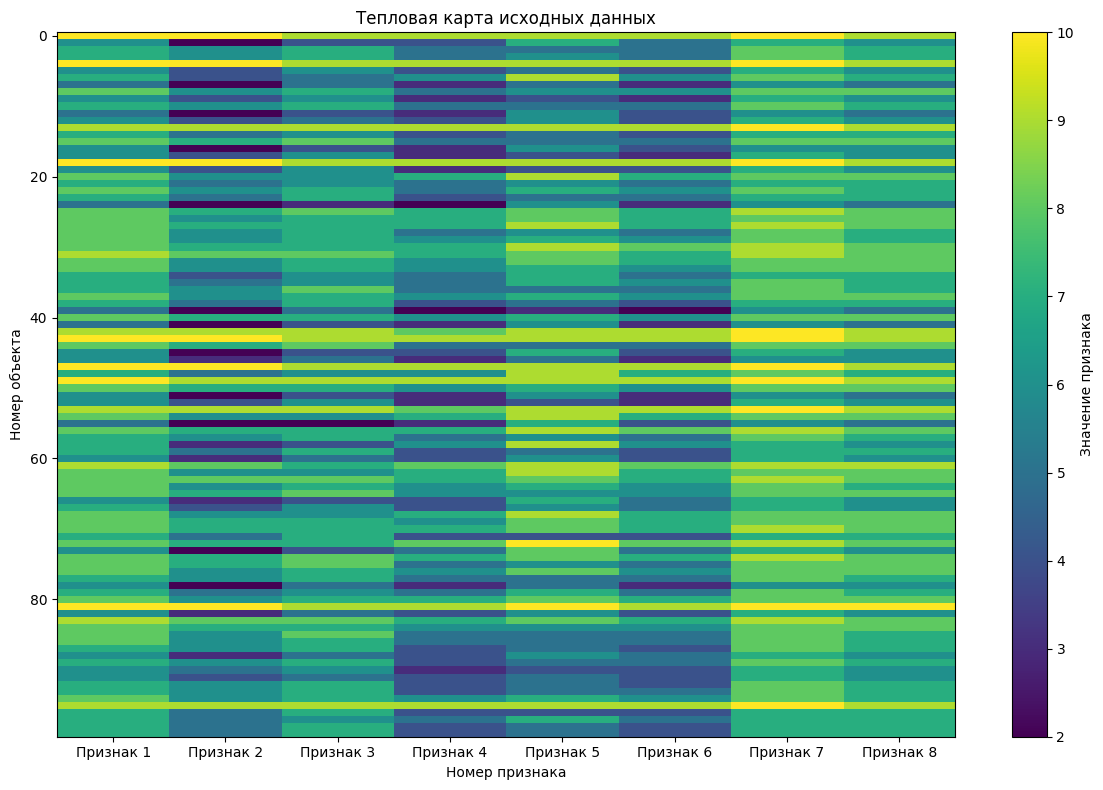

In [193]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

learning_data = np.loadtxt("./ЛР_7/Data_Lab7/Learning_data2.txt")

plt.figure(figsize=(12, 8))
plt.imshow(learning_data, cmap='viridis', aspect='auto')
plt.colorbar(label='Значение признака')
plt.title('Тепловая карта исходных данных')
plt.xlabel('Номер признака')
plt.ylabel('Номер объекта')
plt.xticks(range(learning_data.shape[1]), [f'Признак {i+1}' for i in range(learning_data.shape[1])])
plt.tight_layout()
plt.show()


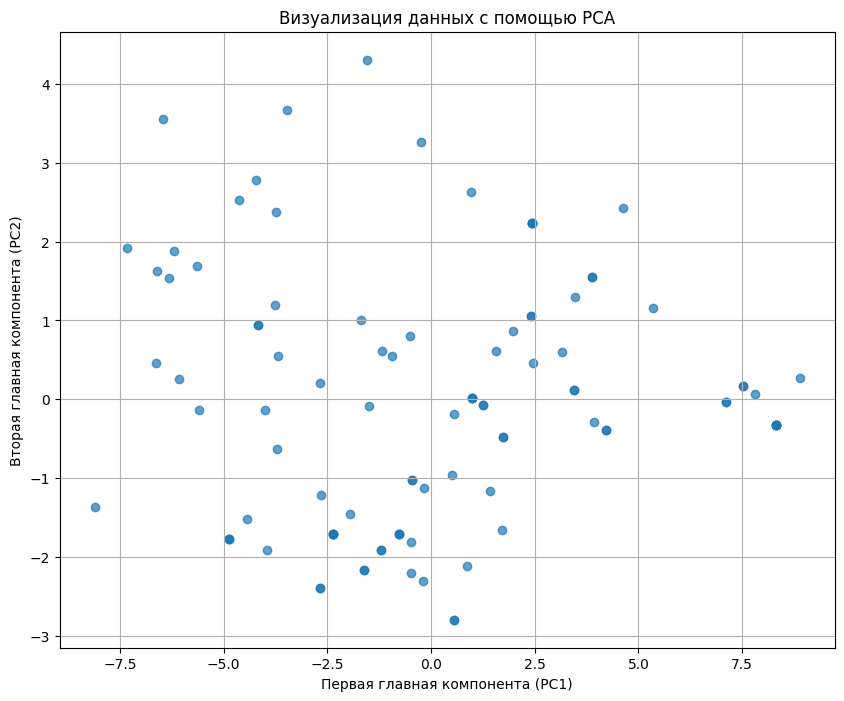

Объясненная дисперсия компонентами PC1 и PC2: 0.85, 0.13
Суммарная объясненная дисперсия: 0.97


In [194]:
from sklearn.decomposition import PCA

# Применение PCA для снижения размерности до 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(learning_data)

with open('pca_res.txt', "+w") as file:
    arr = pca_result.tolist()
    
    file.write(
        "\n".join(map(lambda x: f"{x[0]:.4f}\t\t{x[1]:.4f}", arr))
    )

# Визуализация данных в пространстве первых двух главных компонент
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
plt.title('Визуализация данных с помощью PCA')
plt.xlabel('Первая главная компонента (PC1)')
plt.ylabel('Вторая главная компонента (PC2)')
plt.grid(True)
plt.show()

# Вывод объясненной дисперсии
explained_variance = pca.explained_variance_ratio_
print(f'Объясненная дисперсия компонентами PC1 и PC2: {explained_variance[0]:.2f}, {explained_variance[1]:.2f}')
print(f'Суммарная объясненная дисперсия: {sum(explained_variance):.2f}')


In [195]:
scaler = MinMaxScaler()
learning_data_scaled = scaler.fit_transform(learning_data)

map_size = (2, 2)
input_dim = learning_data.shape[1] 
epochs = 100
learning_rate = 0.5 
radius = max(map_size) / 2

np.random.seed(42)
weights = np.random.rand(map_size[0], map_size[1], input_dim)
neighborhood_decay = -np.log(radius) / epochs
learning_rate_decay = -np.log(learning_rate) / epochs

def neuron_distance(pos1, pos2):
    return np.sqrt(np.sum((np.array(pos1) - np.array(pos2))**2))

for epoch in range(epochs):
    # Коэффициенты обучения и радиуса соседства уменьшаются со временем
    current_lr = learning_rate * np.exp(-learning_rate_decay * epoch)
    current_radius = radius * np.exp(-neighborhood_decay * epoch)
    
    # Случайное перемешивание данных
    indices = np.random.permutation(learning_data_scaled.shape[0])
    
    for idx in indices:
        sample = learning_data_scaled[idx]
        
        # Находим нейрон-победитель (BMU)
        bmu_pos = (0, 0)
        min_dist = float('inf')
        
        for i in range(map_size[0]):
            for j in range(map_size[1]):
                dist = np.linalg.norm(sample - weights[i, j, :])
                if dist < min_dist:
                    min_dist = dist
                    bmu_pos = (i, j)
        
        # Обновляем веса для BMU и его соседей
        for i in range(map_size[0]):
            for j in range(map_size[1]):
                dist_to_bmu = neuron_distance((i, j), bmu_pos)
                if dist_to_bmu <= current_radius:
                    # Гауссова функция соседства
                    influence = np.exp(-(dist_to_bmu**2) / (2 * (current_radius**2)))
                    # Обновление весов
                    weights[i, j, :] += current_lr * influence * (sample - weights[i, j, :])

print(f"Обучение сети Кохонена завершено за {epochs} эпох")


Обучение сети Кохонена завершено за 100 эпох


In [196]:
# Классификация объектов в кластеры
classes = []
for sample in learning_data_scaled:
    # Находим нейрон-победитель для каждого образца
    min_dist = float('inf')
    bmu_pos = (0, 0)
    
    for i in range(map_size[0]):
        for j in range(map_size[1]):
            dist = np.linalg.norm(sample - weights[i, j, :])
            if dist < min_dist:
                min_dist = dist
                bmu_pos = (i, j)
    
    # Преобразуем 2D позицию в линейный индекс кластера
    cluster_index = bmu_pos[0] * map_size[1] + bmu_pos[1]
    classes.append(cluster_index)

# Переводим в numpy массив для удобства
classes = np.array(classes)

# Выводим количество объектов в каждом кластере
for i in range(map_size[0] * map_size[1]):
    print(f"Кластер {i}: {np.sum(classes == i)} объектов")

Кластер 0: 10 объектов
Кластер 1: 30 объектов
Кластер 2: 47 объектов
Кластер 3: 13 объектов


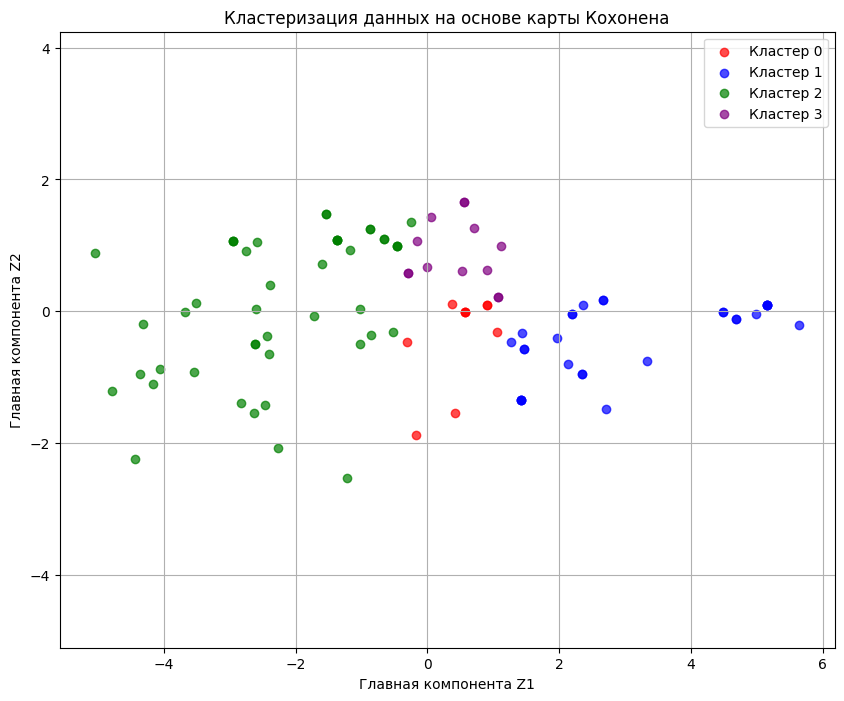

In [197]:

pca_data = np.loadtxt("./ЛР_7/Data_Lab7/PCA_data2.txt")

# Визуализация результатов кластеризации в пространстве главных компонент
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple']

for i in range(map_size[0] * map_size[1]):
    # Выбираем точки, принадлежащие i-му кластеру
    cluster_points = pca_data[classes == i]
    if len(cluster_points) > 0:
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[i], 
                    label=f'Кластер {i}', alpha=0.7)

plt.title('Кластеризация данных на основе карты Кохонена')
plt.xlabel('Главная компонента Z1')
plt.ylabel('Главная компонента Z2')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [198]:
cluster_data = {}

with open('cluster_min_val.txt', "+w") as file:
    for i in range(map_size[0] * map_size[1]):
        # Выбираем оригинальные (ненормализованные) данные для i-го кластера
        cluster_points = learning_data[classes == i]
        cluster_data[i] = cluster_points
        
        if len(cluster_points) > 0:
            # Рассчитываем средние значения признаков для кластера
            mean_features = np.mean(cluster_points, axis=0)
            print(f"\nКластер {i} (среднее значение признаков):")
            file.write(f"\nКластер {i} (среднее значение признаков):\n")
            for j, mean_val in enumerate(mean_features):
                print(f"  Признак {j+1}: {mean_val:.2f}")
                file.write(f"  Признак {j+1}: {mean_val:.2f}\n")
            
            
            


Кластер 0 (среднее значение признаков):
  Признак 1: 7.70
  Признак 2: 5.60
  Признак 3: 6.60
  Признак 4: 5.80
  Признак 5: 7.50
  Признак 6: 6.10
  Признак 7: 8.00
  Признак 8: 7.30

Кластер 1 (среднее значение признаков):
  Признак 1: 8.70
  Признак 2: 7.83
  Признак 3: 7.77
  Признак 4: 7.67
  Признак 5: 8.73
  Признак 6: 7.87
  Признак 7: 9.10
  Признак 8: 8.43

Кластер 2 (среднее значение признаков):
  Признак 1: 6.34
  Признак 2: 3.96
  Признак 3: 5.62
  Признак 4: 3.87
  Признак 5: 5.49
  Признак 6: 4.15
  Признак 7: 6.98
  Признак 8: 6.28

Кластер 3 (среднее значение признаков):
  Признак 1: 7.85
  Признак 2: 6.54
  Признак 3: 7.38
  Признак 4: 5.31
  Признак 5: 5.85
  Признак 6: 5.38
  Признак 7: 8.00
  Признак 8: 7.62


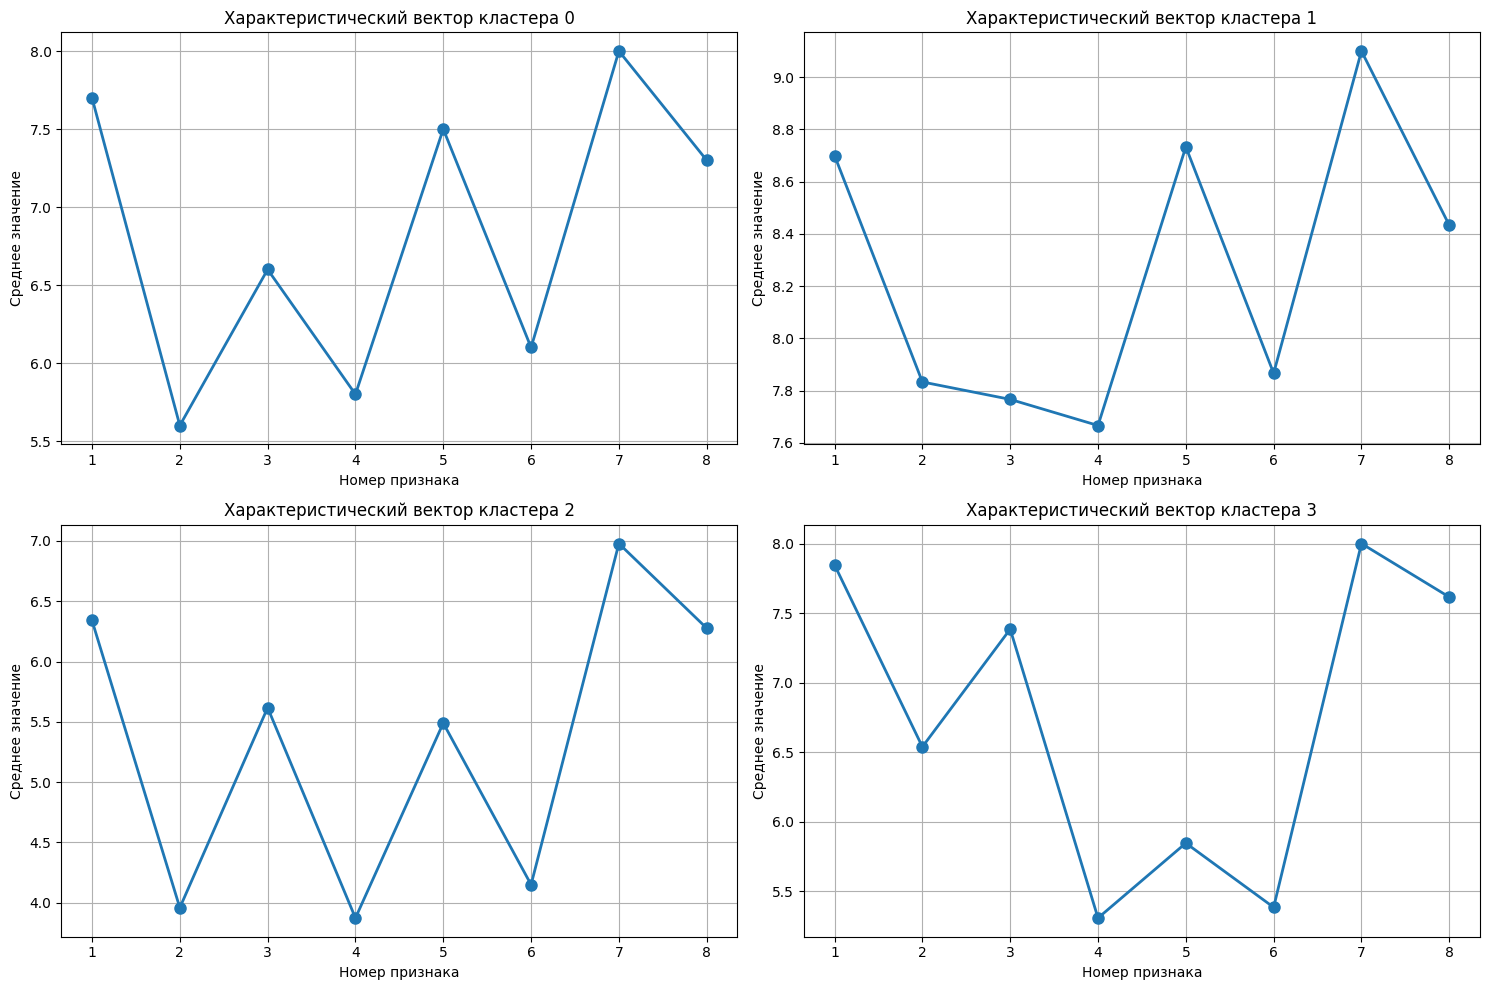

In [199]:
# Построение графиков средних значений признаков для каждого кластера
plt.figure(figsize=(15, 10))

# Количество признаков
num_features = learning_data.shape[1]
feature_indices = np.arange(1, num_features + 1)

for i in range(map_size[0] * map_size[1]):
    if i < len(cluster_data) and len(cluster_data[i]) > 0:
        plt.subplot(2, 2, i + 1)  # 2x2 сетка графиков
        
        # Средние значения признаков в кластере
        mean_features = np.mean(cluster_data[i], axis=0)
        
        plt.plot(feature_indices, mean_features, 'o-', linewidth=2, markersize=8)
        plt.title(f'Характеристический вектор кластера {i}')
        plt.xlabel('Номер признака')
        plt.ylabel('Среднее значение')
        plt.grid(True)
        plt.xticks(feature_indices)

plt.tight_layout()
plt.show()

In [200]:
# Отображение проекций объектов на оси Z1 и Z2 для каждого кластера
with open('d.txt', 'w+') as file:
    for i in range(map_size[0] * map_size[1]):
        if len(cluster_data[i]) > 0:
            # Выбираем точки PCA для i-го кластера
            cluster_pca = pca_data[classes == i]
            
            print(f"\nПроекции объектов кластера {i} на оси Z1 и Z2:")
            file.write(f"\nПроекции объектов кластера {i} на оси Z1 и Z2:\n")
            
            for j, point in enumerate(cluster_pca):
                print(f"  Объект {j+1}: Z1 = {point[0]:.2f}, Z2 = {point[1]:.2f}")
                file.write(f"  Объект {j+1}: Z1 = {point[0]:.2f}, Z2 = {point[1]:.2f}\n")


Проекции объектов кластера 0 на оси Z1 и Z2:
  Объект 1: Z1 = -0.17, Z2 = -1.89
  Объект 2: Z1 = 0.37, Z2 = 0.11
  Объект 3: Z1 = 0.57, Z2 = -0.01
  Объект 4: Z1 = 0.90, Z2 = 0.09
  Объект 5: Z1 = -0.32, Z2 = -0.47
  Объект 6: Z1 = 0.90, Z2 = 0.09
  Объект 7: Z1 = 0.42, Z2 = -1.54
  Объект 8: Z1 = 0.57, Z2 = -0.01
  Объект 9: Z1 = 1.06, Z2 = -0.31
  Объект 10: Z1 = 0.57, Z2 = -0.01

Проекции объектов кластера 1 на оси Z1 и Z2:
  Объект 1: Z1 = 5.16, Z2 = 0.09
  Объект 2: Z1 = 5.16, Z2 = 0.09
  Объект 3: Z1 = 4.69, Z2 = -0.12
  Объект 4: Z1 = 5.16, Z2 = 0.09
  Объект 5: Z1 = 1.42, Z2 = -1.35
  Объект 6: Z1 = 2.19, Z2 = -0.04
  Объект 7: Z1 = 1.47, Z2 = -0.58
  Объект 8: Z1 = 2.14, Z2 = -0.81
  Объект 9: Z1 = 2.34, Z2 = -0.96
  Объект 10: Z1 = 2.66, Z2 = 0.18
  Объект 11: Z1 = 1.27, Z2 = -0.46
  Объект 12: Z1 = 4.49, Z2 = -0.01
  Объект 13: Z1 = 5.16, Z2 = 0.09
  Объект 14: Z1 = 5.16, Z2 = 0.09
  Объект 15: Z1 = 4.99, Z2 = -0.04
  Объект 16: Z1 = 4.49, Z2 = -0.01
  Объект 17: Z1 = 1.42,

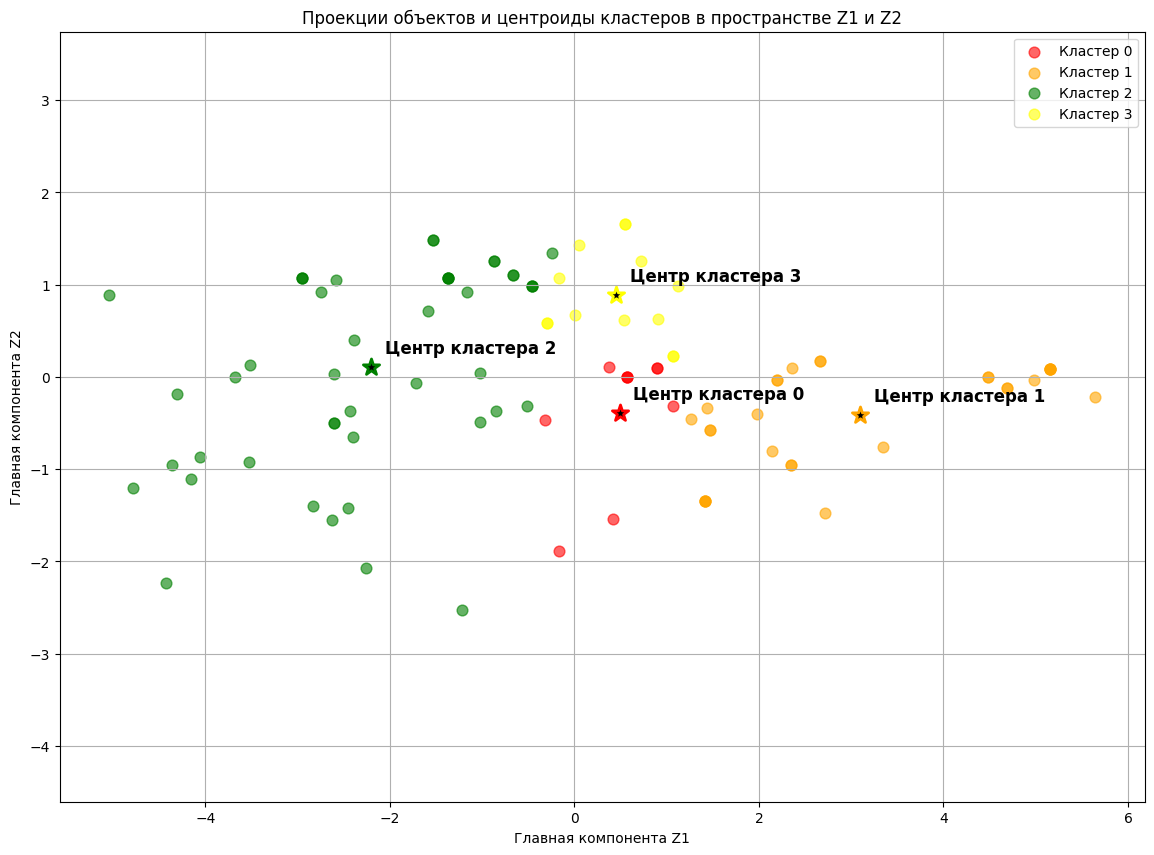

In [204]:
plt.figure(figsize=(14, 10))
colors = ['red', 'orange', 'green', 'yellow']

for i in range(map_size[0] * map_size[1]):
    cluster_pca = pca_data[classes == i]
    if len(cluster_pca) > 0:
        # Отображаем точки кластера
        plt.scatter(cluster_pca[:, 0], cluster_pca[:, 1], 
                   c=colors[i], label=f'Кластер {i}', alpha=0.6, s=60)
        
        # Вычисляем и отображаем центроид кластера
        centroid = np.mean(cluster_pca, axis=0)
        plt.scatter(centroid[0], centroid[1], 
                  c='black', s=150, marker='*', 
                  edgecolor=colors[i], linewidth=2)
        
        # Добавляем метку кластера к центроиду
        plt.annotate(f"Центр кластера {i}",
                    (centroid[0], centroid[1]),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=12, fontweight='bold')

plt.title('Проекции объектов и центроиды кластеров в пространстве Z1 и Z2')
plt.xlabel('Главная компонента Z1')
plt.ylabel('Главная компонента Z2')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()